<h1>Using pre-trained embeddings with TensorFlow Hub</h1>

This notebook illustrates:
<ol>
    <li>How to instantiate a TensorFlow Hub module</li>
    <li>How to find pre-trained TensorFlow Hub modules for a variety of purposes</li>
    <li>How to examine the embeddings of a Hub module</li>
    <li>How one Hub module composes representations of sentences from individual words</li>
    <li>How to assess word embeddings using a semantic similarity test</li>
</ol>

In [2]:
# change these to try this notebook out# chang 
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'

Install the TensorFlow Hub library

In [ ]:
!pip install -q tensorflow-hub

In [33]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import scipy
import math

os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '1.8'

In [ ]:
import tensorflow as tf
print(tf.__version__)

<h2>TensorFlow Hub Concepts</h2>

TensorFlow Hub is a library for the publication, discovery, and consumption of reusable parts of machine learning models. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks in a process known as transfer learning, which we covered as part of the course on Image Models.

To download and use a module, it's as easy as:

However, because modules are self-contained parts of a TensorFlow graph, in order to actually collect values from a module, you'll need to evaluate it in the context of a session.

First, let's explore what hub modules there are. Go to [https://www.tensorflow.org/hub/modules/] and explore a bit.

Note that TensorFlow Hub has modules for Images, Text, and Other. In this case, we're interested in a Text module, so navigate to the Text section.

Within the Text section, there are a number of modules. If you click on a link, you'll be taken to a page that describes the module and links to the original paper where the model was proposed. Click on a model in the Word2Vec section of the page.

Note the details section, which describes what the module expects as input, how it preprocesses data, what it does when it encounters a word it hasn't seen before (OOV means "out of vocabulary") and in this case, how word embeddings can be composed to form sentence embeddings.

Finally, note the URL of the page. This is the URL you can copy to instantiate your module.

<h2>Task 1: Create an embedding using the NNLM model</h2>

To complete this task:
<ol>
    <li>Find the module URL for the NNLM 50 dimensional English model</li>
    <li>Use it to instantiate a module as 'embed'</li>
    <li>Print the embedded representation of "cat"</li>
</ol>

NOTE: downloading hub modules requires downloading a lot of data. Instantiating the module will take a few minutes.

In [28]:
# Task 1
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/nnlm-en-dim50/1"
embed = hub.Module(module_url)
embeddings = embed(["cat"])
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    print(sess.run(embeddings))

[[ 0.11233182 -0.3176392  -0.01661182 -0.07224456  0.18654485 -0.13343827
   0.14713244 -0.05857142 -0.1187038  -0.09351522  0.32281369 -0.07136346
  -0.09905618  0.12076239 -0.13954093 -0.00105632  0.31129223  0.09696656
   0.1131188  -0.2877357   0.02663439  0.11532657 -0.17533781 -0.11511131
  -0.1570579   0.20969287 -0.15480006 -0.00777875  0.13566507  0.07828814
   0.08037776 -0.00566911 -0.17601766  0.04775887  0.0203435  -0.11961495
  -0.01772922 -0.02686167 -0.09766243  0.16661587  0.19552311 -0.06655143
   0.07954271 -0.14783832 -0.00695672  0.22246888 -0.14037196 -0.12318342
  -0.02290071  0.04016034]]


When I completed this exercise, I got a vector that looked like [[ 0.11233182 -0.3176392  -0.0166118...]]

<h2>Task 2: Assess the Embeddings Informally</h2>

<ol>
    <li>Identify some words to test</li>
    <li>Retrieve the embeddings for each word</li>
    <li>Determine what method to use to compare each pair of embeddings</li>
</ol>    

So, now we have some vectors but the question is, are they any good? One way of testing whether they are any good is to try them for your task. But, first, let's just take a peak. 

For our test, we'll need three common words such that two of the words are much closer in meaning than the third.

In [22]:
word_1 = "cat"
word_2 = "dog"
word_3 = "potato"

Now, we'll use the same process of using our Hub module to generate embeddings but instead of printing the embeddings, capture them in a variable called 'my_embeddings'.

In [40]:
# Task 2b
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)
messages = [word_1, word_2, word_3]
def create_embeddings(messages, embed):
    my_embeddings = None
    with tf.Session() as session:
      session.run([tf.global_variables_initializer(), tf.tables_initializer()])
      message_embeddings = session.run(embed(messages))
      my_embeddings = np.array(message_embeddings)
      for i, message_embedding in enumerate(np.array(my_embeddings).tolist()):
        print("Message: {}".format(messages[i]))
        print("Embedding size: {}".format(len(message_embedding)))
        message_embedding_snippet = ", ".join(
            (str(x) for x in message_embedding[:3]))
        print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
    return my_embeddings
my_embeddings = create_embeddings(messages, embed)


Message: cat
Embedding size: 50
Embedding: [0.112331815064, -0.31763920188, -0.0166118238121, ...]

Message: dog
Embedding size: 50
Embedding: [0.235001400113, -0.248348265886, -0.0831891149282, ...]

Message: potato
Embedding size: 50
Embedding: [0.234230294824, -0.341526716948, -0.160279750824, ...]



Now, we'll use Seaborn's heatmap function to see how the vectors compare to each other. I've written the shell of a function that you'll need to complete that will generate a heatmap. The one piece that's missing is how we'll compare each pair of vectors. Note that because we are computing a score for every pair of vectors, we should have len(my_embeddings)^2 scores. There are many valid ways of comparing vectors. Generality, similarity scores are symmetric. The simplest is to take their dot product. For extra credit, implement a more complicated vector comparison function.

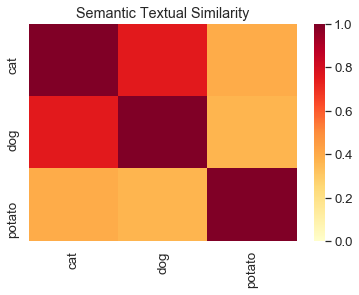

In [27]:
def plot_similarity(labels, embeddings):
  corr = np.inner(embeddings, embeddings)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=90)
  g.set_title("Semantic Textual Similarity")

plot_similarity([word_1, word_2, word_3], my_embeddings)

What you should observe is that, trivially, all words are identical to themselves, and, more interestingly, that the two more similar words have more similar embeddings than the third word.

<h2>Task 3: From Words to Sentences</h2>

Up until now, we've used our module to produce representations of words. But, in fact, if we want to, we can also use it to construct representations of sentences. The methods used by the module to compose a representation of a sentence won't be as nuanced as what an RNN might do, but they are still worth examining because they are so convenient.

<ol>
    <li> Examine the documentation for our hub module and determine how to ask it to construct a representation of a sentence</li>
    <li> Figure out how the module takes word embeddings and uses them to construct sentence embeddings </li>
    <li> Construct a embeddings of a "cat", "The cat sat on the mat", "dog" and "The cat sat on the dog"  and plot their similarity
</ol>

Message: cat
Embedding size: 50
Embedding: [0.112331815064, -0.31763920188, -0.0166118238121, ...]

Message: The cat sat on the mat
Embedding size: 50
Embedding: [0.258387356997, 0.0326247885823, 0.198126375675, ...]

Message: dog
Embedding size: 50
Embedding: [0.235001400113, -0.248348265886, -0.0831891149282, ...]

Message: The cat sat on the dog
Embedding size: 50
Embedding: [0.274633437395, -0.0248483475298, 0.170186281204, ...]



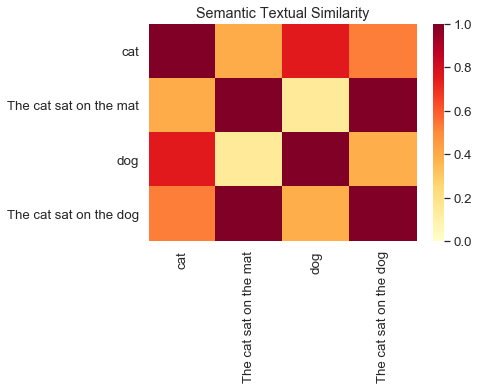

In [41]:
messages = ["cat", "The cat sat on the mat", "dog", "The cat sat on the dog"]
my_embeddings = create_embeddings(messages, embed)
plot_similarity(messages, my_embeddings)

Which is cat more similar to, "The cat sat on the mat" or "dog"? Is this desireable?

Think back to how an RNN scans a sequence and maintains its state. Naive methods of embedding composition (mapping many to one) can't possibly compete with a network trained for this very purpose!

<h2>Task 4: Assessing the Embeddings Formally</h2>
Of course, it's great to know that our embeddings match our intuitions to an extent, but it'd be better to have a formal, data-driven measure of the quality of the representation.

Researchers have
The STS Benchmark http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. Pearson correlation is then used to evaluate the quality of the machine similarity scores against human judgements.

In [13]:
def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
  sent_pairs = []
  with tf.gfile.GFile(filename, "r") as f:
    for line in f:
      ts = line.strip().split("\t")
      # (sent_1, sent_2, similarity_score)
      sent_pairs.append((ts[5], ts[6], float(ts[4])))
  return pd.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
  sts_dataset = tf.keras.utils.get_file(
      fname="Stsbenchmark.tar.gz",
      origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
      extract=True)

  sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
  sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

  return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

Take a look at the data. The sim score is higher when the sentences are more similar and lower when they are not.

In [15]:
sts_dev.head()

,sent_1,sent_2,sim
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00
1,A young child is riding a horse.,A child is riding a horse.,4.75
2,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00
3,A woman is playing the guitar.,A man is playing guitar.,2.40
4,A woman is playing the flute.,A man is playing a flute.,2.75


<h3>Build the Evaluation Graph</h3>

Next, we need to build the evaluation graph.

In [30]:
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1), axis=1)
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2), axis=1)
cosine_similarities = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)
clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
sim_scores = 1.0 - tf.acos(clip_cosine_similarities)

<h3>Evaluate Sentence Embeddings</h3>

Finally, we need to create a session and run our evaluation.

In [31]:
sts_data = sts_dev #@param ["sts_dev", "sts_test"] {type:"raw"}

In [34]:
text_a = sts_data['sent_1'].tolist()
text_b = sts_data['sent_2'].tolist()
dev_scores = sts_data['sim'].tolist()

def run_sts_benchmark(session):
  """Returns the similarity scores"""
  emba, embb, scores = session.run(
      [sts_encode1, sts_encode2, sim_scores],
      feed_dict={
          sts_input1: text_a,
          sts_input2: text_b
      })
  return scores


with tf.Session() as session:
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = 0.518441568346
p-value = 5.88691059978e-104


<h3>Extra Credit</h3>

For extra credit, re-run this analysis with a different Hub module. Are the results different? If so, how?

<h2>Further Reading</h2>

We published a [blog post](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html) on how bias can affect text embeddings. It's worth a read!